#### *Applied Mathematical Finance 2*

## <ins> *Lab 2: Asian basket pricing* </ins>

The deadline is 23:59 on 4th of May, 2025. The solution must be sent up to the deadline on amf2-2025-spring@yandex.ru.


You are given an Asian basket option on underlyings $S^1$ and $S^2$ nominated in the same currency. The parameters of the product are the following 

* Two observation dates $t_1$ = `20/09/2023` and $t_2$ = `20/03/2024`;

* Strike price $K = 220$;

* Payoff at $t_2$ is $\left( \dfrac{S^1_{t_1} + S^1_{t_2} + S^2_{t_1} + S^2_{t_2}}{4} - K \right)_{+}$.

Also assume that 

* The value date $t_0$ is `20/03/2023`;

* The continuously-compounded risk-free rate $r=10\%$;

* The spot underlyings at $t_0$ are $S^1_{t_0} = 185$ and $S^1_{t_0} = 200$;

* The instanteneous log-correlation is $60\%$;

* The volatility smiles for $S^1$ and $S^2$ observed at $t_0$ for corresponding expiry dates $t_1$ and $t_2$ are given in `lab2.csv`.

We also need some technical assumptions: 

* The volatility day count convention is `Act365`, meaning that for volatility handling we assume that the day count fractions equal to the actual number of days in period devided by 365. 

* The volatilites are given as standard Black volatitilities.

* The smile interpolation method is natural cubic splines in $\sigma^2$ over $\log(K)$ coordinates.

* The smile extrapolation method is linear in $\sigma^2$ over $\log(K)$ coordinates.

* The instanteneous volatility $\sigma(t)$ can be assumed pieceiwise constant in between $t_0, t_1$ and $t_2$ and calibrated to at-the-forward implied volatilities.

### 1. Pricing with moment-matching technique (40 points)

Price a desсribed above Asian basket option with moment-matching method (see lecture 3, seminar 3).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, Union
from scipy.stats import norm
import pandas as pd
import warnings
from scipy.interpolate import PchipInterpolator, CubicSpline, interp1d
from cardano_method import CubicEquation
from datetime import date
warnings.filterwarnings('ignore')

In [2]:
def act365(date_1: date, date_2: date) -> float:
    if date_2 < date_1:
        raise "date_2 < date_1"
    return (date_2 - date_1).days / 365

In [3]:
def discount_factors_on_pillar_dates(dates: np.ndarray, rates: np.ndarray):
    """
    Returns discount factors for pillar dates. 

    Args: 
        dates: dates at which the discount factors are computed. 
        rates: zero-rates from which the discount factors are transformed. 
    """
    return np.exp(- dates * rates) # Assume continous compounding convention. 

In [4]:
def build_dicount_factor_curve_based_on_pillar_discount_factors(
    dates: np.ndarray,
    discount_factors: np.ndarray
):
    """
    Build discount factor curve based on pillar discount factors. Linear interpolation in \log(DF(t, T)) wrt T assumed. 

    Args: 
        dates: dates at which the discount factors are given. 
        discount: the discount factors to interpolate. 
    """
    log_discount_factors = np.log(discount_factors)
    intepolator = interp1d(x=dates, y=log_discount_factors, kind="linear", fill_value="extrapolate")
    return lambda x: np.exp(intepolator(x))


In [5]:
def equity_forward(S_ref: float, rate: float):
    """
    Calculates the equity forward F(t, T).  

    Args: 
        S_ref: spot value. 
        rate: risk-free rate.
    """
    return np.vectorize(lambda t, T: S_ref * np.exp(rate*(T - t)))


In [6]:
def volatility_interpolator(strikes: np.ndarray, volatilities: np.ndarray):
    """
    Returns the volatility interpolator.
    """
    # monotone cubic splines interpolator
    return lambda x: np.sqrt(CubicSpline(x=np.log(strikes), y=volatilities**2, bc_type='natural', extrapolate = False)(x))

def volatility_extrapolator(strikes: np.ndarray, volatilities: np.ndarray):
    """
    Returns the volatility interpolator.
    """
    # monotone cubic splines interpolator
    return lambda x: np.sqrt(interp1d(x=np.log(strikes), y=volatilities**2, fill_value='extrapolate')(x))



In [7]:
def create_implied_vol_curves(periods: np.array, strikes: np.ndarray, volatilities: np.ndarray):
    """
    Crates interpolated implied vol curves and corresponding strikes for each tenor. 

    Args:
        periods: array of periods from implied vol termstrucutre backbone. 
        strikes: array of all strikes. 
        volatilities: 2d array of volatilities. 
    """
    period_to_strikes_and_volatility_curve_mapping = dict()
    for i, period in enumerate(periods):
        volatilities_per_period = volatilities[i]
        nont_null_vol_mask = ~np.isnan(volatilities_per_period)
        selected_strikes = strikes[nont_null_vol_mask]
        selected_vols = volatilities_per_period[nont_null_vol_mask]

        vol_interpolator = volatility_interpolator(strikes=selected_strikes, 
                                                   volatilities=selected_vols) # monotone cubic splines interpolator

        period_to_strikes_and_volatility_curve_mapping[period] = {"strikes": selected_strikes,
                                                                  "vols": vol_interpolator}
    return period_to_strikes_and_volatility_curve_mapping

def create_extrapolated_implied_vol_curves(periods: np.array, strikes: np.ndarray, volatilities: np.ndarray):
    """
    Crates extrapolator implied vol curves and corresponding strikes for each tenor. 

    Args:
        periods: array of periods from implied vol termstrucutre backbone. 
        strikes: array of all strikes. 
        volatilities: 2d array of volatilities. 
    """
    period_to_strikes_and_volatility_curve_mapping = dict()
    for i, period in enumerate(periods):
        volatilities_per_period = volatilities[i]
        nont_null_vol_mask = ~np.isnan(volatilities_per_period)
        selected_strikes = strikes[nont_null_vol_mask]
        selected_vols = volatilities_per_period[nont_null_vol_mask]

        vol_interpolator = volatility_extrapolator(strikes=selected_strikes, 
                                                   volatilities=selected_vols)

        period_to_strikes_and_volatility_curve_mapping[period] = {"strikes": selected_strikes,
                                                                  "vols": vol_interpolator}
    return period_to_strikes_and_volatility_curve_mapping

In [8]:
def get_instanteneous_volatilities_at_the_forwards(
    periods_floats: np.ndarray, 
    periods: np.ndarray, forwards_at_periods: np.ndarray, 
    period_to_strikes_and_volatility_curve_mapping: dict
):
    """
    Computes instanteneous volatilites \sigma_{i, i + 1}(s) for a given period [t_i, t_{i + 1}]. 

    Args:
        periods_floats: array of periods at which instanteneous volatilites are computed. 
        periods: string representations of periods at which instanteneous volatilites are computed. 
        forwards_at_periods: forwards at given periods.  
        period_to_strikes_and_volatility_curve_mapping: t_i -> iv_smile(t_i) mapping.  
    """
    n = len(periods_floats)
    # instanteneous_volatilities = np.zeros_like(periods)
    instanteneous_volatilities = []

    for i, _ in enumerate(periods_floats):
        if (i == 0) | (i == n - 1):
            # print(periods[i])
            strikes_and_volatility_curve_mapping = period_to_strikes_and_volatility_curve_mapping[periods[i]]
            # print(np.log(forwards_at_periods[i]))
            # print(strikes_and_volatility_curve_mapping["vols"](np.log(forwards_at_periods[i])))
            instanteneous_volatilities.append(
                float(strikes_and_volatility_curve_mapping["vols"](np.log(forwards_at_periods[i])))
            )
            # print(
            #     float(strikes_and_volatility_curve_mapping["vols"](np.log(forwards_at_periods[i])))
            # )
            # print(instanteneous_volatilities)
            # print("")
        else:
            # print("new")
            strikes_and_volatility_curve_mapping_1 = period_to_strikes_and_volatility_curve_mapping[periods[i - 1]] 
            strikes_and_volatility_curve_mapping_2 = period_to_strikes_and_volatility_curve_mapping[periods[i]] 

            variance_1 = (strikes_and_volatility_curve_mapping_1["vols"](np.log(forwards_at_periods[i - 1]))) ** 2 * periods_floats[i - 1]
            variance_2 = (strikes_and_volatility_curve_mapping_2["vols"](np.log(forwards_at_periods[i]))) ** 2 * periods_floats[i]

            instanteneous_volatilities[i] = np.sqrt((variance_2 - variance_1) / (periods_floats[i] - periods_floats[i - 1]))
    
    return np.array(instanteneous_volatilities)

In [9]:
def get_forwards_at_periods(forwards, dates, periods):
    """
    Returns the forward prices at given periods. 

    Args:
        forwards: array of forwards at dates. 
        dates: array of dates at which forwards are given.
        periods: periods for which forwards should be computed. 
    """
    forwards_at_periods = np.zeros_like(periods)
    for i, period in enumerate(periods):
        index_of_period = np.where(periods == period)[0][0]
        date = dates[index_of_period]
        forwards_at_periods[i] = forwards[date]
    return forwards_at_periods

In [10]:
def get_log_covariance(instanteneous_volatilities_at_periods_1: np.ndarray,
                       instanteneous_volatilities_at_periods_2: np.ndarray,
                       periods_floats: np.ndarray, correlation: float, t: float):
    """
    Returns the log-covariances c_ij(t) = \rho_ij \cdot \int_{0}^{t} \sigma_i(s) \sigma_j(s) ds.

    Args:
        instanteneous_volatilities_at_periods_1: array of instanteneous volatilities \sigma_1(s) for s from array of periods.
        instanteneous_volatilities_at_periods_2: array of instanteneous volatilities \sigma_1(s) for s from array of periods. 
        periods_floats: array of periods at which instanteneous volatilites are computed. 
        correlation: the correlation between brownian motions W^1 and W^2 driving the S^1 and S^2. 
        t: the time point at which the log-covariance is computed. 
    """
    if t <= periods_floats[0]:
        return correlation * instanteneous_volatilities_at_periods_1[0] * instanteneous_volatilities_at_periods_2[0] * t
    
    if np.abs(periods_floats[0]) > 1e-8:
        periods_floats = np.insert(periods_floats, 0, 0)

    # print(periods_floats)
    periods_before = np.where(periods_floats  <= t)[0]
    # print(periods_before)
    # print(periods_before[-1] - 1)

    periods_strictly_before = periods_before[:-1]
    periods_floats_diffs = np.diff(periods_floats)
    # print(periods_before[-1])
    # print()
    integral_ = np.sum(periods_floats_diffs[periods_strictly_before] * instanteneous_volatilities_at_periods_1[periods_strictly_before] * instanteneous_volatilities_at_periods_2[periods_strictly_before])
    integral = integral_ + (t - periods_floats[periods_before[-1]]) * instanteneous_volatilities_at_periods_1[periods_before[-1] - 1] * instanteneous_volatilities_at_periods_2[periods_before[-1] - 1]
    return integral * correlation


In [11]:
def get_log_autocovariance(
    instanteneous_volatilities_at_periods: np.ndarray,
    periods_floats: np.ndarray
):
    """
    Returns the log-autocovariances c_ij(t) = \cdot \int_{0}^{t_i ^ t_j} \sigma^2(s) ds.

    Args:
        instanteneous_volatilities_at_periods: array of instanteneous volatilities \sigma(s) for s from array of periods.
        periods_floats: array of periods at which instanteneous volatilites are computed. 
    """
    return periods_floats[0]*instanteneous_volatilities_at_periods[0]**2



In [12]:
def get_log_covariances_matrix(instanteneous_volatilities_at_periods_1: np.ndarray,
                               instanteneous_volatilities_at_periods_2: np.ndarray,
                               periods_floats: np.ndarray, correlation: float, t: float):
    """
    Computes log-covariance Cov[\log(S^i_t), \log(S^j_t)] = \rho \int_{0}^{t} \sigma_i(s) \sigma_j(s) ds matrix, i,j=1,2. 

    Args:
        instanteneous_volatilities_at_periods_1: array of instanteneous volatilities \sigma_1(s) for s from array of periods.
        instanteneous_volatilities_at_periods_2: array of instanteneous volatilities \sigma_1(s) for s from array of periods. 
        periods_floats: array of periods at which instanteneous volatilites are computed. 
        correlation: the correlation between brownian motions W^1 and W^2 driving the S^1 and S^2. 
        t: the time point at which the log-covariance matrix is computed. 
    """
    log_variance_1_1 = get_log_covariance(
        instanteneous_volatilities_at_periods_1=instanteneous_volatilities_at_periods_1, 
        instanteneous_volatilities_at_periods_2=instanteneous_volatilities_at_periods_1,
        periods_floats=periods_floats,
        correlation=1, t=periods_floats[0]
    )
    log_variance_2_1 = get_log_autocovariance(
        instanteneous_volatilities_at_periods=instanteneous_volatilities_at_periods_1, 
        periods_floats=periods_floats,
    )
    log_variance_2_2 = get_log_covariance(
        instanteneous_volatilities_at_periods_1=instanteneous_volatilities_at_periods_1, 
        instanteneous_volatilities_at_periods_2=instanteneous_volatilities_at_periods_1,
        periods_floats=periods_floats,
        correlation=1, t=periods_floats[1]
        # correlation=correlation, t=periods_floats[0]
        # correlation=1, t=periods_floats[0]
        # correlation=correlation, t=periods_floats[0]
    )
    log_variance_3_1 = get_log_covariance(
        instanteneous_volatilities_at_periods_1=instanteneous_volatilities_at_periods_1, 
        instanteneous_volatilities_at_periods_2=instanteneous_volatilities_at_periods_2,
        periods_floats=periods_floats,
        correlation=correlation, t=periods_floats[0]
    )
    log_variance_3_2 = get_log_covariance(
        instanteneous_volatilities_at_periods_1=instanteneous_volatilities_at_periods_1, 
        instanteneous_volatilities_at_periods_2=instanteneous_volatilities_at_periods_2,
        periods_floats=periods_floats,
        correlation=correlation, t=periods_floats[0]
    )
    log_variance_3_3 = get_log_covariance(
        instanteneous_volatilities_at_periods_1=instanteneous_volatilities_at_periods_2, 
        instanteneous_volatilities_at_periods_2=instanteneous_volatilities_at_periods_2,
        periods_floats=periods_floats,
        correlation=1, t=periods_floats[0]
    )
    log_variance_4_1 = get_log_covariance(
        instanteneous_volatilities_at_periods_1=instanteneous_volatilities_at_periods_1, 
        instanteneous_volatilities_at_periods_2=instanteneous_volatilities_at_periods_2,
        periods_floats=periods_floats,
        correlation=correlation, t=periods_floats[0]
    )
    log_variance_4_2 = get_log_covariance(
        instanteneous_volatilities_at_periods_1=instanteneous_volatilities_at_periods_1, 
        instanteneous_volatilities_at_periods_2=instanteneous_volatilities_at_periods_2,
        periods_floats=periods_floats,
        correlation=correlation, t=periods_floats[1]
        # correlation=1, t=periods_floats[1]
        # correlation=correlation, t=periods_floats[0]
        # correlation=1, t=periods_floats[0]
        # correlation=correlation, t=periods_floats[0]
    )
    log_variance_4_3 = get_log_autocovariance(
        instanteneous_volatilities_at_periods=instanteneous_volatilities_at_periods_2, 
        periods_floats=periods_floats,
    )
    log_variance_4_4 = get_log_covariance(
        instanteneous_volatilities_at_periods_1=instanteneous_volatilities_at_periods_2, 
        instanteneous_volatilities_at_periods_2=instanteneous_volatilities_at_periods_2,
        periods_floats=periods_floats,
        correlation=1, t=periods_floats[1]
        # correlation=correlation, t=periods_floats[0]
        # correlation=1, t=periods_floats[0]
        # correlation=correlation, t=periods_floats[0]
    )
    return np.array([
        [log_variance_1_1, log_variance_2_1, log_variance_3_1, log_variance_4_1], 
        [log_variance_2_1, log_variance_2_2, log_variance_3_2, log_variance_4_2],
        [log_variance_3_1, log_variance_3_2, log_variance_3_3, log_variance_4_3],
        [log_variance_4_1, log_variance_4_2, log_variance_4_3, log_variance_4_4],
    ])

In [13]:
def moment_matching(forwards: np.array, log_covariance: np.array, weights: np.array):
    """
    Computes the desired forward F, strike adjustment \delta and implied standard deviation \sigma.

    Args:
        forwards: an array of forwards of corresponding assets, i.e. F^1(t, T) and F^2(t, T)
        log_covariance: a matrix of log covariances cov[\log(S^i_T), \log(S^j_T)], i = 1, 2.
        weights: an array of weights of corresponding assets in options payoff. 
    """
    covariance = np.exp(log_covariance)
    weighted_forwards = forwards * weights
    m1 = np.sum(weighted_forwards)
    m2 = (weighted_forwards) @ covariance @ (weighted_forwards).T
    B = ((weighted_forwards.T * covariance) @ covariance) * covariance
    m3 = weighted_forwards @ B @ (weighted_forwards).T

    mu_2 = m2 - m1 ** 2
    mu_3 = m3 - 3 * m1 * m2 + 2 * m1 ** 3

    F = CubicEquation([1, - 3 * mu_2 ** 2 / mu_3, 0, - mu_2 ** 3 / mu_3]).answers[0].real
    delta = F - m1
    sigma = np.sqrt(np.log(1 + mu_2 / (F ** 2)))

    return F, delta, sigma

In [14]:
def black_price_formula(F: float,
                        K: Union[float, np.ndarray],
                        T: float,
                        sigma: Union[float, np.ndarray],
                        isCall: bool = True,
                        df: float = 1) -> Union[float, np.ndarray]:
    """Pricing formula from Black76. Broadcasts in both forward and strike.

    Args:
        F: forward.
        K: grid of strikes.
        T: tenor.
        sigma: implied volatility.
        isCall: type of option (True if Call, False if Put).
        df: discount factor. 

    Returns 2D array in spot (rows) and strikes (columns) grid.
    """
    if isinstance(K, (float, int)):
        assert isinstance(sigma, (float, int)), "K and sigma should both either floats or np.ndarrays"
    elif isinstance(K, np.ndarray):
        assert isinstance(sigma, np.ndarray), "K and sigma should both either floats or np.ndarrays"
    else:
        raise TypeError("K and sigma should both either floats or np.ndarrays")
    
    stddev = sigma * np.sqrt(T)
    d1 = np.log(F / K) / stddev + 0.5 * stddev
    d2 = d1 - stddev
    theta = 1.0 if isCall else -1.0
    return df * theta * (F * norm.cdf(theta * d1) - K * norm.cdf(theta * d2))

In [15]:
t0 = date(2023, 3, 20)
obs_date_1 = date(2023, 9, 20)
obs_date_2 = date(2024, 3, 20)
maturity = date(2024, 3, 20)

K = 220
r = 0.1
S_1_t0 = 185
S_2_t0 = 200
corr = 0.6

dates = np.array([
    obs_date_1, obs_date_2
])
periods_floats = np.array([
    act365(t0, obs_date_1),
    act365(t0, obs_date_2)
])
risk_free_rates = np.full(np.shape(periods_floats), r)


vol = pd.read_csv("lab2.csv", sep=";")
vol = vol.drop("Unnamed: 0", axis=1)

temp_columns = [
    col for col in vol.columns 
        if vol[col].dtype == 'object' and 
            vol[col].apply(lambda x: str(x).endswith('%') if pd.notnull(x) else False).any()
]

for col in temp_columns:
    vol[col] = vol[col].str.rstrip('%').astype(float) / 100

In [16]:
vol

,K1,iv1_1,iv1_2,K2,iv2_1,iv2_2
0,79,0.4794,0.4862,90,0.4080,0.3659
1,95,0.4604,0.4680,108,0.3694,0.3415
2,103,0.4518,0.4598,117,0.3529,0.3310
3,110,0.4438,0.4520,126,0.3380,0.3214
4,118,0.4362,0.4447,135,0.3246,0.3128
5,126,0.4290,0.4378,144,0.3126,0.3050
6,134,0.4222,0.4313,153,0.3019,0.2979
7,142,0.4157,0.4250,162,0.2927,0.2916
8,150,0.4095,0.4191,171,0.2849,0.2859
9,158,0.4037,0.4134,180,0.2787,0.2810


In [17]:
risk_free_dfs = discount_factors_on_pillar_dates(dates=periods_floats, rates=risk_free_rates)
risk_free_dfs_curve = build_dicount_factor_curve_based_on_pillar_discount_factors(
    dates=periods_floats, 
    discount_factors=risk_free_dfs
)


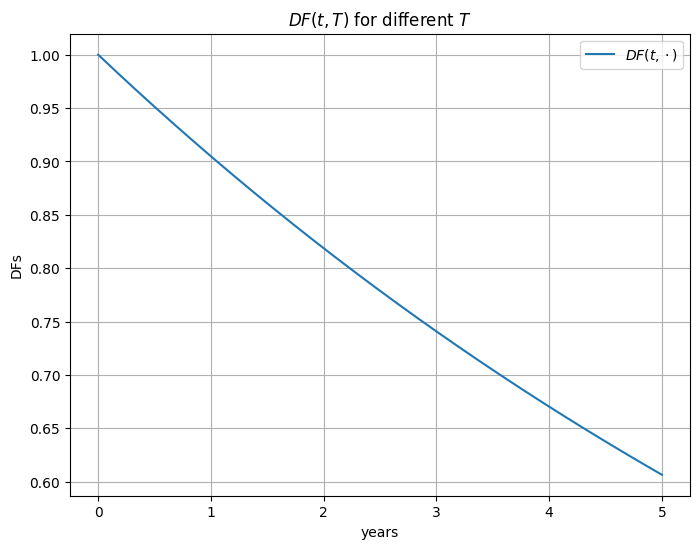

In [18]:
T = 5; t = 0

time_greed = np.linspace(t, T, int(T * 12 * 21))

plt.figure(figsize=(8, 6))
plt.title("$DF(t, T)$ for different $T$")
plt.plot(time_greed, risk_free_dfs_curve(time_greed), label="$DF(t, \cdot)$")
plt.xlabel("years")
plt.ylabel("DFs")
plt.grid()
plt.legend()
plt.show()

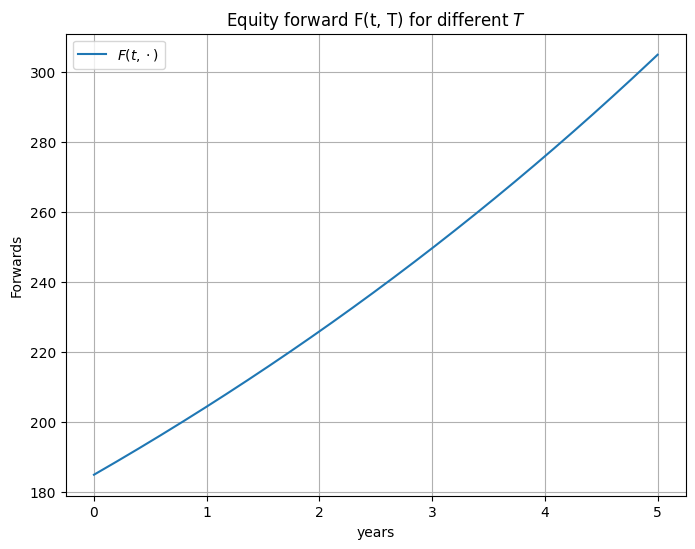

In [19]:
T = 5; t = 0
time_greed = np.linspace(t, T, int(T * 12 * 21))
equity_forward_curve_first = equity_forward(S_ref=S_1_t0, rate=r)
equity_forward_curve_second = equity_forward(S_ref=S_2_t0, rate=r)


plt.figure(figsize=(8, 6))
plt.title("Equity forward F(t, T) for different $T$")
plt.plot(time_greed, equity_forward_curve_first(t, time_greed), label="$F(t, \cdot)$")
plt.xlabel("years")
plt.ylabel("Forwards")
plt.grid()
plt.legend()
plt.show()

In [20]:
first_forwards = dict(zip(periods_floats, equity_forward_curve_first(0, periods_floats)))
second_forwards = dict(zip(periods_floats, equity_forward_curve_second(0, periods_floats)))
dfs = dict(zip(periods_floats, risk_free_dfs_curve(periods_floats)))

In [21]:
periods = np.array(["6M", "1Y"])
first_strikes = vol["K1"].values.astype(float)
second_strikes = vol["K2"].values.astype(float)

first_period_to_strikes_and_volatility_curve_mapping = create_implied_vol_curves(
    periods=periods, 
    strikes=first_strikes,
    volatilities=vol[["iv1_1", "iv1_2"]].T.values.astype(float)
)

second_period_to_strikes_and_volatility_curve_mapping = create_implied_vol_curves(
    periods=periods, 
    strikes=second_strikes,
    volatilities=vol[["iv2_1", "iv2_2"]].T.values.astype(float)
)

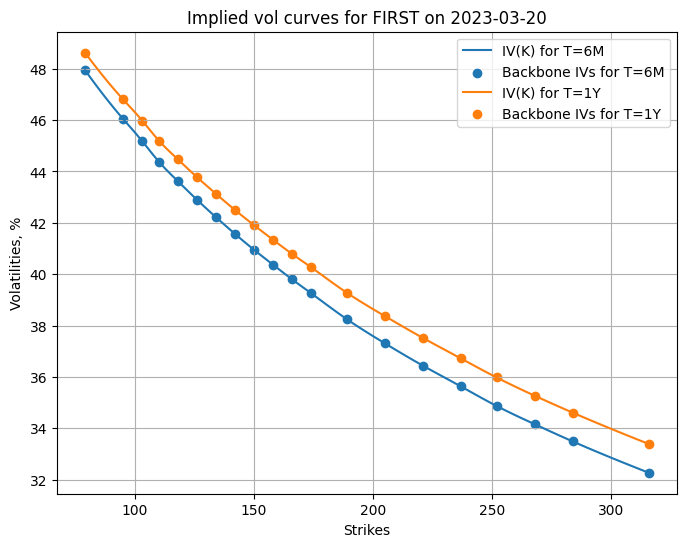

In [22]:
plt.figure(figsize=(8, 6))
for period_to_plot in periods:
    strikes_and_volatility_curve_mapping = first_period_to_strikes_and_volatility_curve_mapping[period_to_plot]
    selected_strikes = strikes_and_volatility_curve_mapping["strikes"]
    vol_interpolator = strikes_and_volatility_curve_mapping["vols"]
    selected_vols = vol_interpolator(np.log(selected_strikes))

    strike_min, strike_max = np.min(selected_strikes), np.max(selected_strikes)
    high_frequency_strikes_grid = np.linspace(strike_min, strike_max, 100)
    
    plt.plot(high_frequency_strikes_grid, vol_interpolator(np.log(high_frequency_strikes_grid)) * 100, label="IV(K) for T={}".format(period_to_plot))
    plt.scatter(selected_strikes, selected_vols * 100, label="Backbone IVs for T={}".format(period_to_plot))

plt.title("Implied vol curves for FIRST on {}".format(t0))
plt.xlabel("Strikes")
plt.ylabel("Volatilities, %")
plt.grid()
plt.legend()
plt.show()

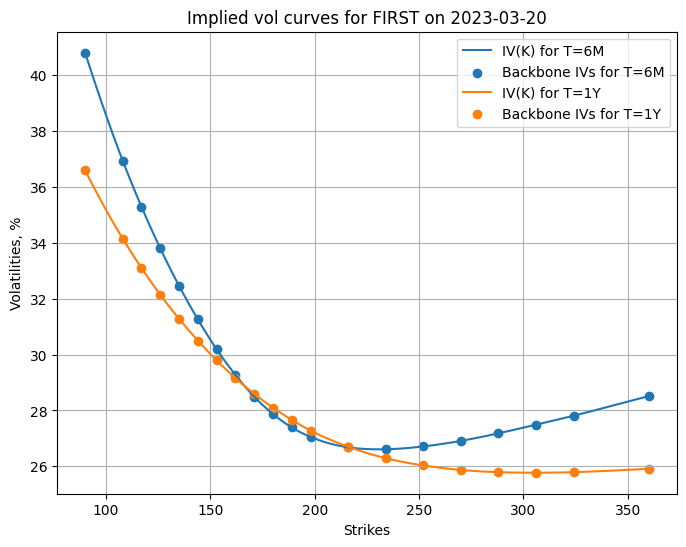

In [23]:
plt.figure(figsize=(8, 6))
for period_to_plot in periods:
    strikes_and_volatility_curve_mapping = second_period_to_strikes_and_volatility_curve_mapping[period_to_plot]
    selected_strikes = strikes_and_volatility_curve_mapping["strikes"]
    vol_interpolator = strikes_and_volatility_curve_mapping["vols"]
    selected_vols = vol_interpolator(np.log(selected_strikes))

    strike_min, strike_max = np.min(selected_strikes), np.max(selected_strikes)
    high_frequency_strikes_grid = np.linspace(strike_min, strike_max, 100)
    
    plt.plot(high_frequency_strikes_grid, vol_interpolator(np.log(high_frequency_strikes_grid)) * 100, label="IV(K) for T={}".format(period_to_plot))
    plt.scatter(selected_strikes, selected_vols * 100, label="Backbone IVs for T={}".format(period_to_plot))

plt.title("Implied vol curves for FIRST on {}".format(t0))
plt.xlabel("Strikes")
plt.ylabel("Volatilities, %")
plt.grid()
plt.legend()
plt.show()

In [24]:
first_instanteneous_volatilities_at_periods =  get_instanteneous_volatilities_at_the_forwards(
    periods_floats=periods_floats, periods=periods, 
    forwards_at_periods=list(first_forwards.values()), 
    period_to_strikes_and_volatility_curve_mapping=first_period_to_strikes_and_volatility_curve_mapping
)

second_instanteneous_volatilities_at_periods =  get_instanteneous_volatilities_at_the_forwards(
    periods_floats=periods_floats, periods=periods, 
    forwards_at_periods=list(second_forwards.values()), 
    period_to_strikes_and_volatility_curve_mapping=second_period_to_strikes_and_volatility_curve_mapping
)

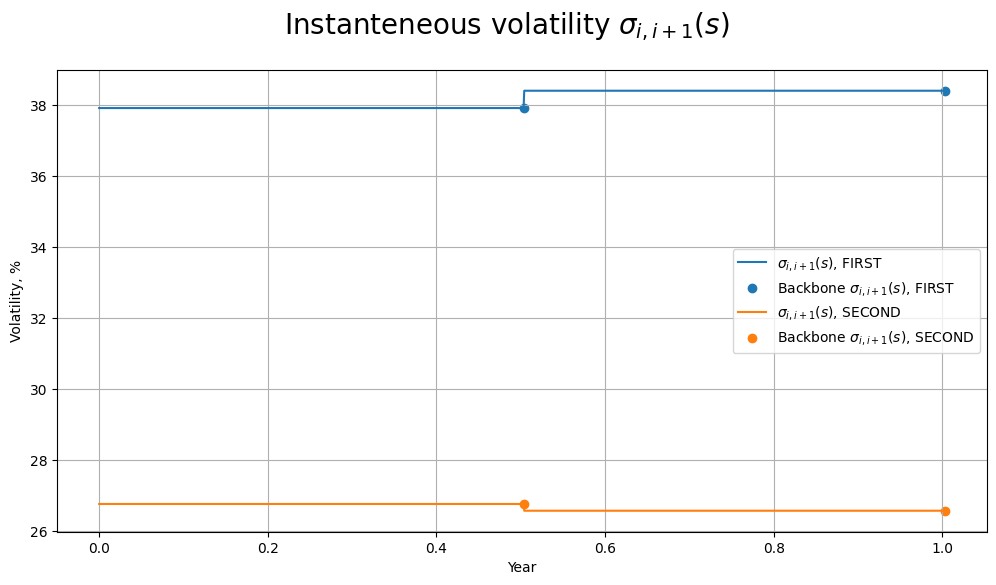

In [25]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6))

first_interpolated_inst_vol = interp1d(x=periods_floats, y=first_instanteneous_volatilities_at_periods, kind="next", fill_value="extrapolate")
second_interpolated_inst_vol = interp1d(x=periods_floats, y=second_instanteneous_volatilities_at_periods, kind="next", fill_value="extrapolate")
high_frequency_times_grid = np.linspace(0, periods_floats[-1], 252 * 5)


axs.plot(high_frequency_times_grid, 100 * first_interpolated_inst_vol(high_frequency_times_grid), label="$\sigma_{i, i+1}(s)$, FIRST")
axs.scatter(periods_floats, 100 * first_instanteneous_volatilities_at_periods, label="Backbone $\sigma_{i, i+1}(s)$, FIRST")

axs.plot(high_frequency_times_grid, 100 * second_interpolated_inst_vol(high_frequency_times_grid), label="$\sigma_{i, i+1}(s)$, SECOND")
axs.scatter(periods_floats, 100 * second_instanteneous_volatilities_at_periods, label="Backbone $\sigma_{i, i+1}(s)$, SECOND")

axs.set_xlabel("Year")
axs.set_ylabel("Volatility, %")
fig.suptitle('Instanteneous volatility $\sigma_{i, i+1}(s)$', fontsize=20)
plt.grid()
plt.legend()
plt.show()

In [26]:
t = periods_floats[1]
log_cov_matrix = get_log_covariances_matrix(
    instanteneous_volatilities_at_periods_1=first_instanteneous_volatilities_at_periods,
    instanteneous_volatilities_at_periods_2=second_instanteneous_volatilities_at_periods,
    periods_floats=periods_floats, correlation=corr, t=t
)

In [27]:
log_cov_matrix

array([[0.07244236, 0.07244236, 0.0306806 , 0.0306806 ],
       [0.07244236, 0.14595471, 0.0306806 , 0.06120028],
       [0.0306806 , 0.0306806 , 0.0360938 , 0.0360938 ],
       [0.0306806 , 0.06120028, 0.0360938 , 0.0712901 ]])

In [28]:
# Basket price
correlation = corr

weights = np.array([0.25, 0.25, 0.25, 0.25])

F_, delta, sigma = moment_matching(forwards=list(first_forwards.values()) + list(second_forwards.values()), 
                                   log_covariance=log_cov_matrix, 
                                   weights=weights)
iv_ = sigma / np.sqrt(t)

basket_price = black_price_formula(F = F_, K = K + delta, T = t, sigma = iv_, isCall=True, df=np.exp(- t * r))
print("Basket forward = {}, strike adjustment = {}, implied variance sigma = {}".format(F_, delta, sigma))
print("Basket price = {}, implied vol = {}".format(basket_price, iv_))

Basket forward = 189.396742, strike adjustment = -18.23154044706095, implied variance sigma = 0.25213424310592375
Basket price = 12.706224315791095, implied vol = 0.25178956181954504


### 2. Pricing with Monte-Carlo (50 points)

Price a desсribed above Asian basket option with Monte-Carlo approach in AMF framework (see lectures 4-5, seminars 4-5).

In [29]:
def get_log_correlation_matrix(
    instanteneous_volatilities_at_periods_1: np.ndarray,
    instanteneous_volatilities_at_periods_2: np.ndarray,
    periods_floats: np.ndarray, correlation: float, t: float
):
    log_variance_2_1 = get_log_autocovariance(
        instanteneous_volatilities_at_periods=instanteneous_volatilities_at_periods_1, 
        periods_floats=periods_floats,
    ) / np.sqrt(
        get_log_covariance(
            instanteneous_volatilities_at_periods_1=instanteneous_volatilities_at_periods_1, 
            instanteneous_volatilities_at_periods_2=instanteneous_volatilities_at_periods_1,
            periods_floats=periods_floats,
            correlation=1, t=periods_floats[1]
        ) * get_log_covariance(
            instanteneous_volatilities_at_periods_1=instanteneous_volatilities_at_periods_1, 
            instanteneous_volatilities_at_periods_2=instanteneous_volatilities_at_periods_1,
            periods_floats=periods_floats,
            correlation=1, t=periods_floats[0]
        )
    )
    log_variance_3_1 = get_log_covariance(
        instanteneous_volatilities_at_periods_1=instanteneous_volatilities_at_periods_1, 
        instanteneous_volatilities_at_periods_2=instanteneous_volatilities_at_periods_2,
        periods_floats=periods_floats,
        correlation=correlation, t=periods_floats[0]
    ) / np.sqrt(
        get_log_covariance(
            instanteneous_volatilities_at_periods_1=instanteneous_volatilities_at_periods_2, 
            instanteneous_volatilities_at_periods_2=instanteneous_volatilities_at_periods_2,
            periods_floats=periods_floats,
            correlation=1, t=periods_floats[0]
        ) * get_log_covariance(
            instanteneous_volatilities_at_periods_1=instanteneous_volatilities_at_periods_1, 
            instanteneous_volatilities_at_periods_2=instanteneous_volatilities_at_periods_1,
            periods_floats=periods_floats,
            correlation=1, t=periods_floats[0]
        )
    )
    log_variance_3_2 = get_log_covariance(
        instanteneous_volatilities_at_periods_1=instanteneous_volatilities_at_periods_1, 
        instanteneous_volatilities_at_periods_2=instanteneous_volatilities_at_periods_2,
        periods_floats=periods_floats,
        correlation=correlation, t=periods_floats[0]
    ) / np.sqrt(
        get_log_covariance(
            instanteneous_volatilities_at_periods_1=instanteneous_volatilities_at_periods_2, 
            instanteneous_volatilities_at_periods_2=instanteneous_volatilities_at_periods_2,
            periods_floats=periods_floats,
            correlation=1, t=periods_floats[0]
        ) * get_log_covariance(
            instanteneous_volatilities_at_periods_1=instanteneous_volatilities_at_periods_1, 
            instanteneous_volatilities_at_periods_2=instanteneous_volatilities_at_periods_1,
            periods_floats=periods_floats,
            correlation=1, t=periods_floats[1]
        )
    )
    log_variance_4_1 = get_log_covariance(
        instanteneous_volatilities_at_periods_1=instanteneous_volatilities_at_periods_1, 
        instanteneous_volatilities_at_periods_2=instanteneous_volatilities_at_periods_2,
        periods_floats=periods_floats,
        correlation=correlation, t=periods_floats[0]
    ) / np.sqrt(
        get_log_covariance(
            instanteneous_volatilities_at_periods_1=instanteneous_volatilities_at_periods_2, 
            instanteneous_volatilities_at_periods_2=instanteneous_volatilities_at_periods_2,
            periods_floats=periods_floats,
            correlation=1, t=periods_floats[1]
        ) * get_log_covariance(
            instanteneous_volatilities_at_periods_1=instanteneous_volatilities_at_periods_1, 
            instanteneous_volatilities_at_periods_2=instanteneous_volatilities_at_periods_1,
            periods_floats=periods_floats,
            correlation=1, t=periods_floats[0]
        )
    )
    log_variance_4_2 = get_log_covariance(
        instanteneous_volatilities_at_periods_1=instanteneous_volatilities_at_periods_1, 
        instanteneous_volatilities_at_periods_2=instanteneous_volatilities_at_periods_2,
        periods_floats=periods_floats,
        correlation=correlation, t=periods_floats[1]
    ) / np.sqrt(
        get_log_covariance(
            instanteneous_volatilities_at_periods_1=instanteneous_volatilities_at_periods_2, 
            instanteneous_volatilities_at_periods_2=instanteneous_volatilities_at_periods_2,
            periods_floats=periods_floats,
            correlation=1, t=periods_floats[1]
        ) * get_log_covariance(
            instanteneous_volatilities_at_periods_1=instanteneous_volatilities_at_periods_1, 
            instanteneous_volatilities_at_periods_2=instanteneous_volatilities_at_periods_1,
            periods_floats=periods_floats,
            correlation=1, t=periods_floats[1]
        )
    )
    log_variance_4_3 = get_log_autocovariance(
        instanteneous_volatilities_at_periods=instanteneous_volatilities_at_periods_2, 
        periods_floats=periods_floats,
    ) / np.sqrt(
        get_log_covariance(
            instanteneous_volatilities_at_periods_1=instanteneous_volatilities_at_periods_2, 
            instanteneous_volatilities_at_periods_2=instanteneous_volatilities_at_periods_2,
            periods_floats=periods_floats,
            correlation=1, t=periods_floats[1]
        ) * get_log_covariance(
            instanteneous_volatilities_at_periods_1=instanteneous_volatilities_at_periods_2, 
            instanteneous_volatilities_at_periods_2=instanteneous_volatilities_at_periods_2,
            periods_floats=periods_floats,
            correlation=1, t=periods_floats[0]
        )
    )
    return np.array([
        [1, log_variance_2_1, log_variance_3_1, log_variance_4_1], 
        [log_variance_2_1, 1, log_variance_3_2, log_variance_4_2],
        [log_variance_3_1, log_variance_3_2, 1, log_variance_4_3],
        [log_variance_4_1, log_variance_4_2, log_variance_4_3, 1],
    ])     

In [30]:
t = periods_floats[1]
log_corr_matrix = get_log_correlation_matrix(
    instanteneous_volatilities_at_periods_1=first_instanteneous_volatilities_at_periods,
    instanteneous_volatilities_at_periods_2=second_instanteneous_volatilities_at_periods,
    periods_floats=periods_floats, correlation=corr, t=t
)

In [31]:
log_corr_matrix

array([[1.        , 0.7045101 , 0.6       , 0.42692635],
       [0.7045101 , 1.        , 0.42270606, 0.59997024],
       [0.6       , 0.42270606, 1.        , 0.71154392],
       [0.42692635, 0.59997024, 0.71154392, 1.        ]])

In [32]:
ext_first_period_to_strikes_and_volatility_curve_mapping = create_extrapolated_implied_vol_curves(
    periods=periods, 
    strikes=first_strikes,
    volatilities=vol[["iv1_1", "iv1_2"]].T.values.astype(float)
)

ext_second_period_to_strikes_and_volatility_curve_mapping = create_extrapolated_implied_vol_curves(
    periods=periods, 
    strikes=second_strikes,
    volatilities=vol[["iv2_1", "iv2_2"]].T.values.astype(float)
)

In [33]:
def probabilities_interpolator(strikes: np.ndarray, probabilities: np.ndarray):
    """
    Returns the probabilities interpolator.
    """
    return interp1d(strikes, probabilities, kind='cubic', fill_value="extrapolate") 

In [34]:
def risk_neutral_probabilities(period_to_strikes_and_volatility_curve_mapping: dict, 
                               periods_floats: float, forwards_at_periods: np.array):
    """
    Returns the risk-neutral distribution from a given implied volatilities for a particular period. 

    Args:
         period_to_strikes_and_volatility_curve_mapping: mapping from a period to a grid of strikes and volatilities. 
         periods_floats: an array of a periods represented by a year fractions. 
         forwards_at_periods: an array of forwards at given periods. 
    """
    density_distribution_mapping = dict()
    for i, (period,  strikes_and_volatility_curve_mapping) in enumerate(period_to_strikes_and_volatility_curve_mapping.items()):
        period_float = periods_floats[i]
        forward = forwards_at_periods[i]
        # print(forward)
        # print(period_float)
        strikes = strikes_and_volatility_curve_mapping["strikes"]
        vol = strikes_and_volatility_curve_mapping["vols"]

        strike_min, strike_max = np.min(strikes) + 1e-4, np.max(strikes) - 1e-4 # min and max strikes
        high_frequency_strikes_grid = np.linspace(strike_min, strike_max, 100) 

        epsilon = 1e-8 # relative shift
        strikes_up_shift = high_frequency_strikes_grid * (1 + epsilon) # strikes bumped upward
        strikes_down_shift = high_frequency_strikes_grid * (1 - epsilon) # strikes bumped downward

        strike_up_shift_vol = vol(np.log(strikes_up_shift)) # vol at K * (1 + ε)
        strike_down_shift_vol = vol(np.log(strikes_down_shift)) # vol at K * (1 - ε)

        # Price the Call with  K * (1 - ε) strike and corresponding implied volatility level
        call_price_down_shift = black_price_formula(F=forward, K=strikes_down_shift, 
                                                    T=period_float, sigma=strike_down_shift_vol, 
                                                    isCall=True, df=1) # Black(F=f, K=K*(1+ε), σ(T,K*(1+ε)))
        # Price the Call with  K * (1 + ε) strike and corresponding implied volatility level
        call_price_up_shift = black_price_formula(F=forward, K=strikes_up_shift, 
                                                  T=period_float, sigma=strike_up_shift_vol, 
                                                  isCall=True, df=1) # Black(F=f, K=K*(1-ε), σ(T,K*(1-ε)))
        # Approximate the deriavetive - dC(K)/dK as (C(K * (1 - ε)) - C(K * (1 + ε))) / (2 * K * ε)

        distribution = 1 - (call_price_down_shift - call_price_up_shift) / (2 * epsilon * high_frequency_strikes_grid) # derivative approximation of -dC(k)/dk

        # print(distribution)        
        density_distribution_mapping[period] = {"strikes": high_frequency_strikes_grid, 
                                                "probabilities": probabilities_interpolator(strikes=high_frequency_strikes_grid, 
                                                                                           probabilities=distribution)}
        # break
    return density_distribution_mapping


In [35]:
risk_neutral_distribution_first = risk_neutral_probabilities(
    period_to_strikes_and_volatility_curve_mapping=first_period_to_strikes_and_volatility_curve_mapping,
    periods_floats=periods_floats, 
    forwards_at_periods=list(first_forwards.values())
)

risk_neutral_distribution_second = risk_neutral_probabilities(
    period_to_strikes_and_volatility_curve_mapping=second_period_to_strikes_and_volatility_curve_mapping,
    periods_floats=periods_floats, 
    forwards_at_periods=list(second_forwards.values())
)

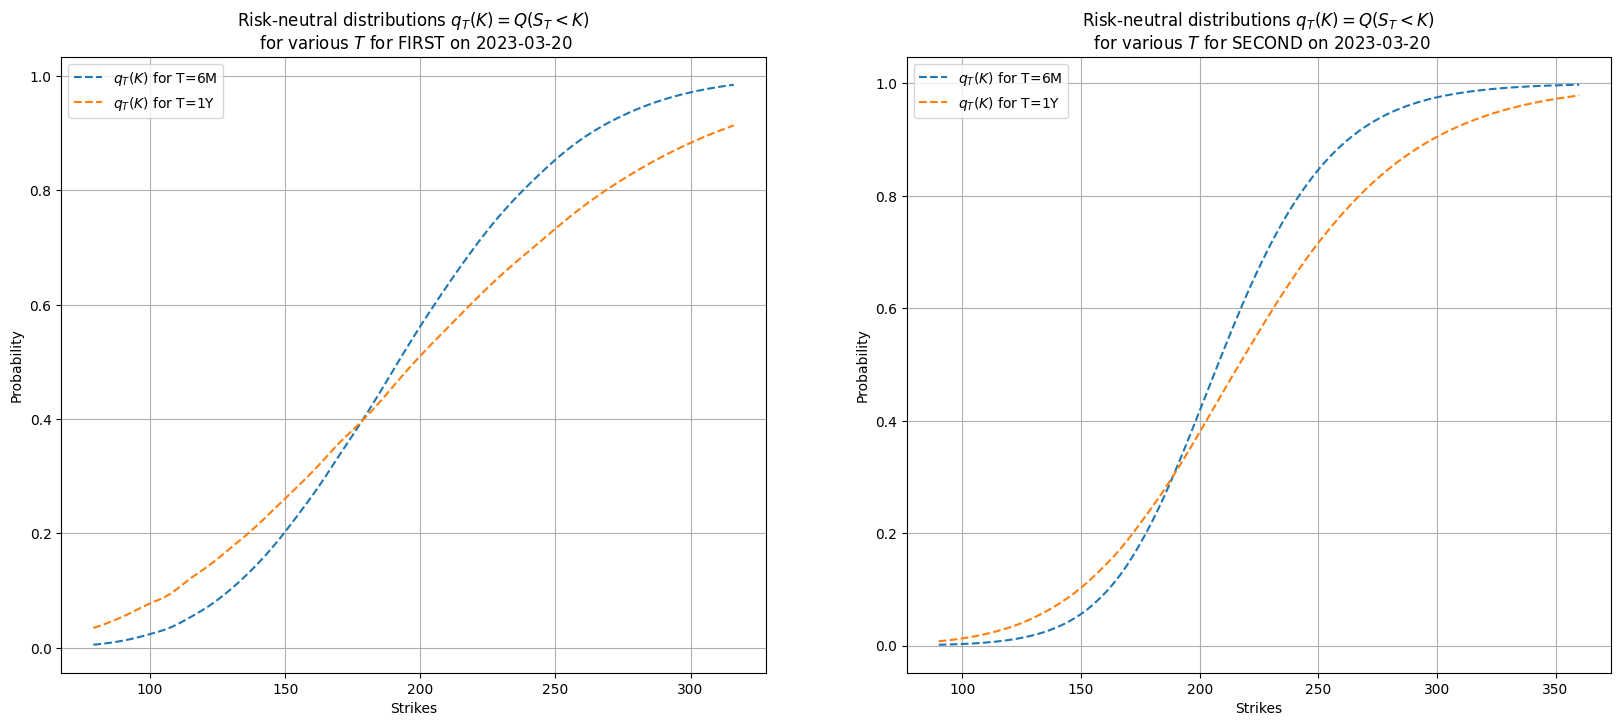

In [36]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

for period_to_plot in periods:
    # print(period_to_plot)
    strikes_and_distributinos_first = risk_neutral_distribution_first[period_to_plot]
    strikes_first, distributions_first  = strikes_and_distributinos_first["strikes"], strikes_and_distributinos_first["probabilities"]
    ax1.plot(strikes_first, distributions_first(strikes_first), label="$q_T(K)$ for T={}".format(period_to_plot), linestyle="dashed")
    # print(strikes_first)
    # print(distributions_first(strikes_first))
    ax1.set_xlabel("Strikes")
    ax1.set_ylabel("Probability")
    ax1.grid(True)
    ax1.legend()
    ax1.set_title("Risk-neutral distributions $q_T(K) = Q(S_T < K)$ \n for various $T$ for FIRST on {}".format(t0))

    strikes_and_distributinos_second = risk_neutral_distribution_second[period_to_plot]
    strikes_second, distributions_second  = strikes_and_distributinos_second["strikes"], strikes_and_distributinos_second["probabilities"]
    ax2.plot(strikes_second, distributions_second(strikes_second), label="$q_T(K)$ for T={}".format(period_to_plot), linestyle="dashed")
    ax2.set_xlabel("Strikes")
    ax2.set_ylabel("Probability")
    ax2.grid(True)
    ax2.legend()
    ax2.set_title("Risk-neutral distributions $q_T(K) = Q(S_T < K)$ \n for various $T$ for SECOND on {}".format(t0))

plt.show()

In [37]:
from typing import Callable
from collections import defaultdict

def create_exponential_lambda(foo: Callable):
   return lambda x: np.exp(foo(x))

def quantile_interpolator(probabilities: np.array, quantiles: np.array):
    """
    Inter-and-extrapolates the quantile function q^{-1}_T(\cdot) in log coordinates.

    Args:
        probabilities: array of probabilities (abscissas)
        quantiles: array of quantiles (ordinates)    
    """
    return interp1d(x=probabilities, y=np.log(quantiles), kind='linear', fill_value="extrapolate")

def quantile_mappings(risk_neutral_distribution: dict):
    """
    Inverts the distribution function q_T(\cdot) to retrieve the quantile q^{-1}_T(\cdot) function. 
    """
    quantile_mappings = defaultdict(dict)
    for period, strikes_and_probabilities in risk_neutral_distribution.items():
        quantile_mappings[period]["probabilities"] = strikes_and_probabilities["probabilities"](strikes_and_probabilities["strikes"])
        quantile_mappings[period]["quantiles"] = create_exponential_lambda(quantile_interpolator(probabilities=quantile_mappings[period]["probabilities"], 
                                                                                                 quantiles=strikes_and_probabilities["strikes"]))
        
    return quantile_mappings

In [38]:
quantile_mappings_first = quantile_mappings(risk_neutral_distribution=risk_neutral_distribution_first)
quantile_mappings_second = quantile_mappings(risk_neutral_distribution=risk_neutral_distribution_second)

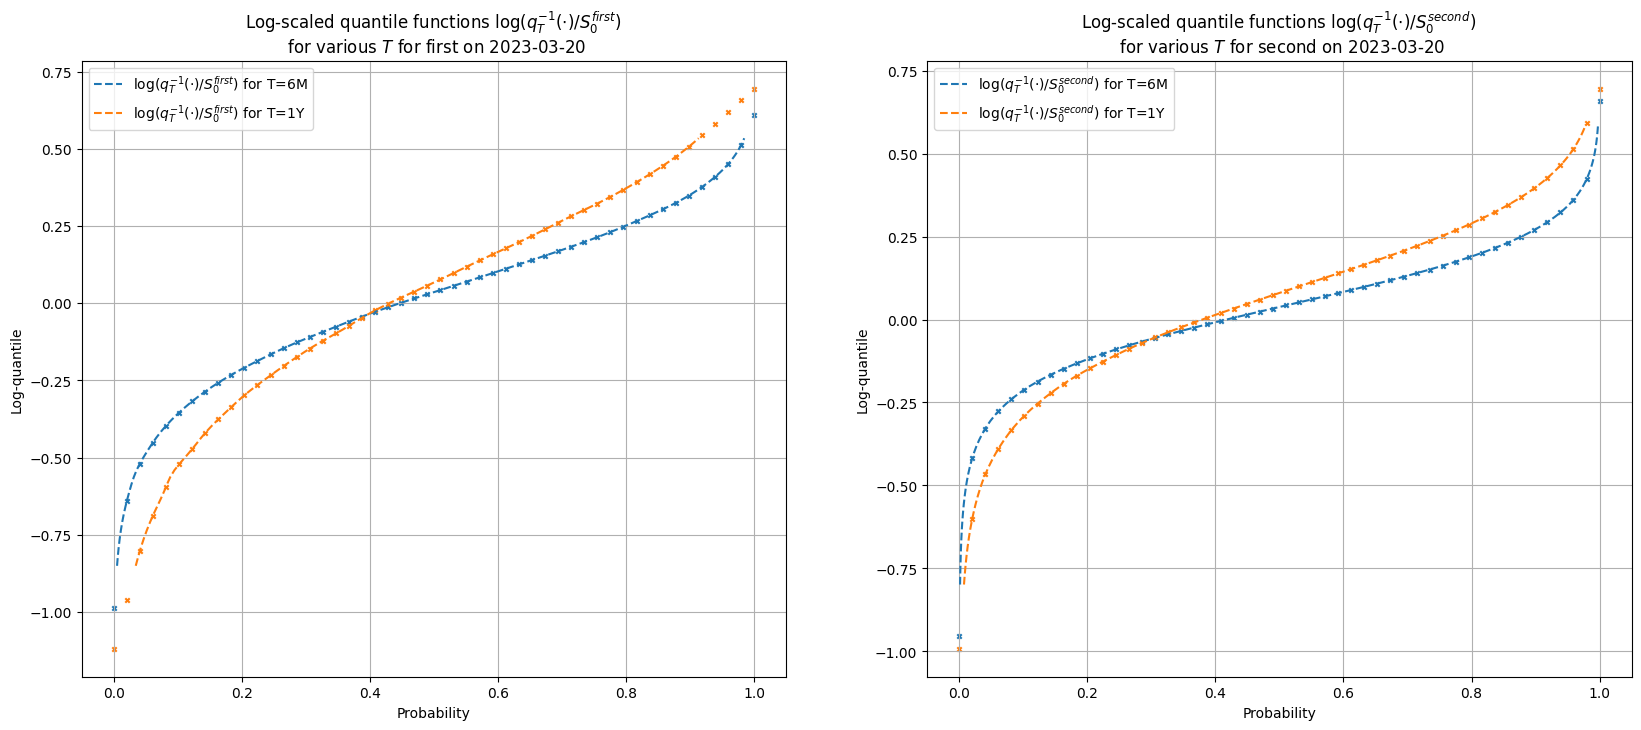

In [39]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

for period_to_plot in periods:
    probabilities_ = np.linspace(0, 1, 50)
    
    # first quantile map
    probabilities_and_quantiles_first = quantile_mappings_first[period_to_plot]
    probabilities_first, quantiles_first  = probabilities_and_quantiles_first["probabilities"], probabilities_and_quantiles_first["quantiles"]

    ax1.scatter(probabilities_, np.log(quantiles_first(probabilities_) / S_1_t0), s=10, marker="x")
    ax1.plot(probabilities_first, np.log(quantiles_first(probabilities_first) / S_1_t0), 
             label="$\log(q_T^{-1}(\cdot) / S^{first}_0)$ for T=" + period_to_plot, linestyle="dashed")
    
    ax1.set_xlabel("Probability")
    ax1.set_ylabel("Log-quantile")
    ax1.grid(True)
    ax1.legend()
    ax1.set_title("Log-scaled quantile functions $\log(q^{-1}_T(\cdot) / S^{first}_0)$ \n for various $T$ for first on " + t0.strftime(format="%Y-%m-%d"))

    # second quantile map
    probabilities_and_quantiles_second = quantile_mappings_second[period_to_plot]
    probabilities_second, quantiles_second  = probabilities_and_quantiles_second["probabilities"], probabilities_and_quantiles_second["quantiles"]

    ax2.scatter(probabilities_, np.log(quantiles_second(probabilities_) / S_2_t0), s=10, marker="x")
    ax2.plot(probabilities_second, np.log(quantiles_second(probabilities_second) / S_2_t0), 
             label="$\log(q_T^{-1}(\cdot) / S^{second}_0)$ for T=" + period_to_plot, linestyle="dashed")
    
    ax2.set_xlabel("Probability")
    ax2.set_ylabel("Log-quantile")
    ax2.grid(True)
    ax2.legend()
    ax2.set_title("Log-scaled quantile functions $\log(q^{-1}_T(\cdot) / S^{second}_0)$ \n for various $T$ for second on " + t0.strftime(format="%Y-%m-%d"))

plt.show()

In [40]:
def sample_independent_uniform_variates(n_sample: int, size: int = 1, random_seed: int = 42):
    np.random.seed(random_seed)
    return np.random.rand(n_sample, size)

In [41]:
def transform_uniform_to_gaussian(uniform_sample: np.ndarray):
    return norm.ppf(uniform_sample)

In [42]:
def transform_gaussian_to_uniform(gaussian_sample: np.ndarray):
    return norm.cdf(gaussian_sample)

In [43]:
def cholesky_decomposition(x: np.ndarray):
    return np.linalg.cholesky(x)

In [44]:
def gaussian_copula(n_sample: int, corr_matrix: np.ndarray):
    size = corr_matrix.shape[0]
    sample_of_independent_uniform_variates = sample_independent_uniform_variates(n_sample=n_sample, size=size)
    sample_of_independent_standard_gaussian_variates = transform_uniform_to_gaussian(uniform_sample=sample_of_independent_uniform_variates)
    square_root_matrix = cholesky_decomposition(x=corr_matrix)
    sample_of_codependent_standard_gaussian_variates =  sample_of_independent_standard_gaussian_variates @ square_root_matrix.T
    sample_of_codependent_uniform_variates = transform_gaussian_to_uniform(gaussian_sample=sample_of_codependent_standard_gaussian_variates)
    return sample_of_codependent_uniform_variates
    

In [45]:
def convergence_analysis(sample_of_codependent_gaussian_variates: np.ndarray, strike: np.ndarray):
    maximum_number_of_iterations = sample_of_codependent_gaussian_variates.shape[0]
    results = np.zeros((int(np.log2(maximum_number_of_iterations)), 1))
    for i in range(results.shape[0]):
        results[i, 0] = payoff(
            sample_of_gaussian_variates_1=sample_of_codependent_gaussian_variates[:2**i, 0],
            sample_of_gaussian_variates_2=sample_of_codependent_gaussian_variates[:2**i, 1],
            sample_of_gaussian_variates_3=sample_of_codependent_gaussian_variates[:2**i, 2],
            sample_of_gaussian_variates_4=sample_of_codependent_gaussian_variates[:2**i, 3],
            strike=strike
        )
    
    return results

In [46]:
def payoff(
    sample_of_gaussian_variates_1: np.array,
    sample_of_gaussian_variates_2: np.array,
    sample_of_gaussian_variates_3: np.array,
    sample_of_gaussian_variates_4: np.array,
    strike: float
): 
    return np.mean(
        # np.maximum(
        #     0.25*(
        #         np.exp(sample_of_gaussian_variates_1) + np.exp(sample_of_gaussian_variates_2) + 
        #         np.exp(sample_of_gaussian_variates_3) + np.exp(sample_of_gaussian_variates_4)) - strike,
        #     0
        # )
        np.maximum(
            0.25*(
                sample_of_gaussian_variates_1 + sample_of_gaussian_variates_2 + 
                sample_of_gaussian_variates_3 + sample_of_gaussian_variates_4) - strike,
            0
        )
    )

In [47]:
def transform_uniform_to_market(
    uniform_sample: np.ndarray,
    risk_neutral_distribution_first,
    risk_neutral_distribution_second,
):
    uniform_sample[:, 0] = risk_neutral_distribution_first["6M"]["quantiles"](uniform_sample[:, 0])
    uniform_sample[:, 1] = risk_neutral_distribution_first["1Y"]["quantiles"](uniform_sample[:, 1])
    uniform_sample[:, 2] = risk_neutral_distribution_second["6M"]["quantiles"](uniform_sample[:, 2])
    uniform_sample[:, 3] = risk_neutral_distribution_second["1Y"]["quantiles"](uniform_sample[:, 3])
    return uniform_sample

In [48]:
sample_of_codependent_uniform_variates = gaussian_copula(n_sample=2**19, corr_matrix=log_corr_matrix)
sample_of_transformed_back_codependent_gaussian_variates =  transform_uniform_to_market(
    uniform_sample=sample_of_codependent_uniform_variates,
    risk_neutral_distribution_first=quantile_mappings_first,
    risk_neutral_distribution_second=quantile_mappings_second,
)

In [49]:
convergence_result = np.exp(-r*t)*convergence_analysis(sample_of_codependent_gaussian_variates=sample_of_transformed_back_codependent_gaussian_variates, 
                                          strike=K)

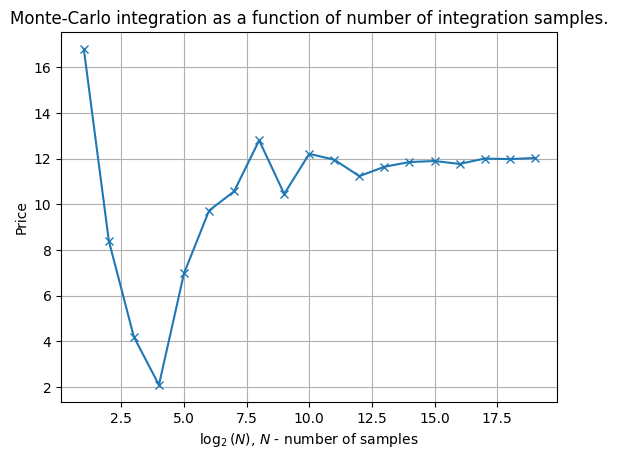

In [50]:
log_2_iteratinos = np.linspace(1, 19, 19)
one_over_sqrt_N = 1 / np.sqrt([2**i for i in range(log_2_iteratinos.shape[0])])
one_over_sqrt_N
plt.plot(log_2_iteratinos, convergence_result[:, 0], marker="x")
plt.title('Monte-Carlo integration as a function of number of integration samples.')
plt.xlabel("$\log_2(N)$, $N$ - number of samples")
plt.ylabel("Price")
plt.grid()
plt.show()

In [51]:
convergence_result[-1]

array([12.02416915])

### 3. Compare the results (10 points)

Compare the results of the used methods above. Is the moment-matching price close to the price retrieved with Monte-Carlo framework? 

Методы в результате дали почти одинаковые цены (в пределах 12-13). Из статьи мы могли бы ожидать, что цена из moment-matching может лежать выше чем из MC. 